In [2]:
from data_querier import DataQuerierYF
from config import load_config
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import pandas as pd
import bahc

In [3]:
configuration = load_config()
data_getter = DataQuerierYF(configuration)

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


In [4]:
from portfolios.mean_variance import MeanVariancePortfolio
from config import load_config
import pandas as pd

configuration = load_config()
portfolio = MeanVariancePortfolio(configuration)
portfolio.data

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,23.816814,4.826837,66.431702,12.591939,NaN,32.449612,18.250000,22.094465,43.607449,28.570000,...,19.624752,26.523653,57.094883,33.148163,21.926781,34.782360,49.557652,35.720001,14.441825,NaN
2012-01-04,23.627478,4.741990,67.989182,12.659608,NaN,32.560421,18.110001,22.008774,43.590977,28.280001,...,19.495548,26.245659,57.108150,33.138783,22.650692,35.019909,48.886963,35.450001,14.760460,NaN
2012-01-05,24.156313,5.156796,68.421783,12.800156,NaN,32.807610,18.270000,21.958122,42.759174,28.480000,...,19.581686,26.474602,56.935547,33.166912,22.327991,35.287136,49.465778,35.400002,15.173820,NaN
2012-01-06,24.417452,5.279352,68.739067,12.933968,NaN,32.892849,18.139999,21.759468,42.685055,28.719999,...,19.524265,26.302898,56.510639,32.970150,21.952948,35.542492,49.594410,35.110001,15.191042,NaN
2012-01-09,25.057270,5.392481,68.719849,12.913449,NaN,32.875797,18.209999,21.755573,42.610931,28.530001,...,19.538618,26.875233,56.762955,32.810883,22.040169,35.405899,49.961906,34.950001,15.397721,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,158.531204,18.170000,236.500000,180.330002,133.029587,131.899994,357.829987,140.962799,414.255981,577.679993,...,66.820000,222.779999,61.889999,55.841362,118.290001,138.009995,127.809998,606.330017,63.009998,246.509995
2021-12-28,158.970612,18.540001,238.130005,179.289993,133.009781,132.360001,357.440002,139.976273,414.196136,569.359985,...,67.620003,220.270004,61.689999,55.921204,119.519997,137.979996,128.210007,597.320007,63.110001,244.250000
2021-12-29,160.438675,18.049999,241.029999,179.380005,133.969818,133.339996,361.839996,140.693741,414.345795,569.289978,...,67.959999,217.619995,61.150002,56.540001,119.360001,138.660004,128.229996,601.119995,63.450001,247.029999


### Cleaning Data

In [6]:
def clean_portfolio(portfolio):
    portfolio.data.fillna(method = 'ffill', inplace = True)
    columns_missing = portfolio.data.columns[portfolio.data.isna().sum() > 10].values
    portfolio.data.drop(columns_missing, inplace= True, axis=1)
    portfolio.data.fillna(method = 'bfill', inplace = True)
    return portfolio

In [7]:
portfolio = clean_portfolio(portfolio)
portfolio.data.shape

(2517, 457)

In [8]:
def get_log_returns_matrix(portfolio_data):
    # returns_matrix = portfolio_data.pct_change()
    log_returns_matrix = np.log(portfolio_data/portfolio_data.shift(1))
    log_returns_matrix.fillna(0, inplace=True)
    log_returns_matrix = log_returns_matrix[(log_returns_matrix.T != 0).any()]
    return log_returns_matrix

In [9]:
import bahc
import numpy as np
import matplotlib.pyplot as plt

In [10]:
portfolio_data = portfolio.data.iloc[:, :50]
log_returns_matrix = get_log_returns_matrix(portfolio_data)
log_returns_matrix.shape

(2516, 50)

### Unfiltered Covariance Matrix

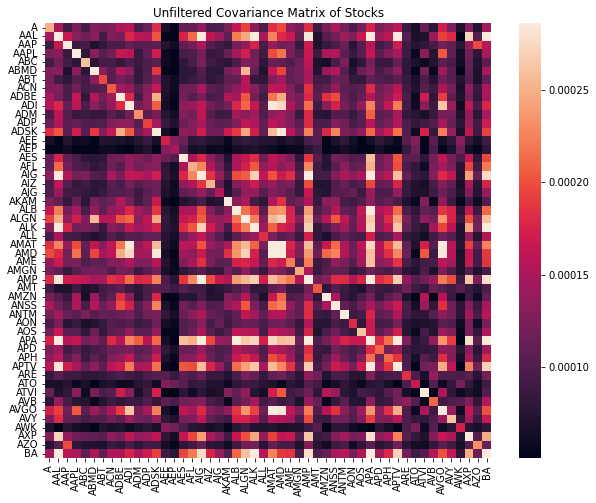

In [11]:
import seaborn as sns
cov_daily = log_returns_matrix.cov()
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cov_daily, 
            xticklabels=True, 
            yticklabels=True,
            robust=True)
plt.title("Unfiltered Covariance Matrix of Stocks")
plt.show()

### Hierarchical Clustering of Stocks

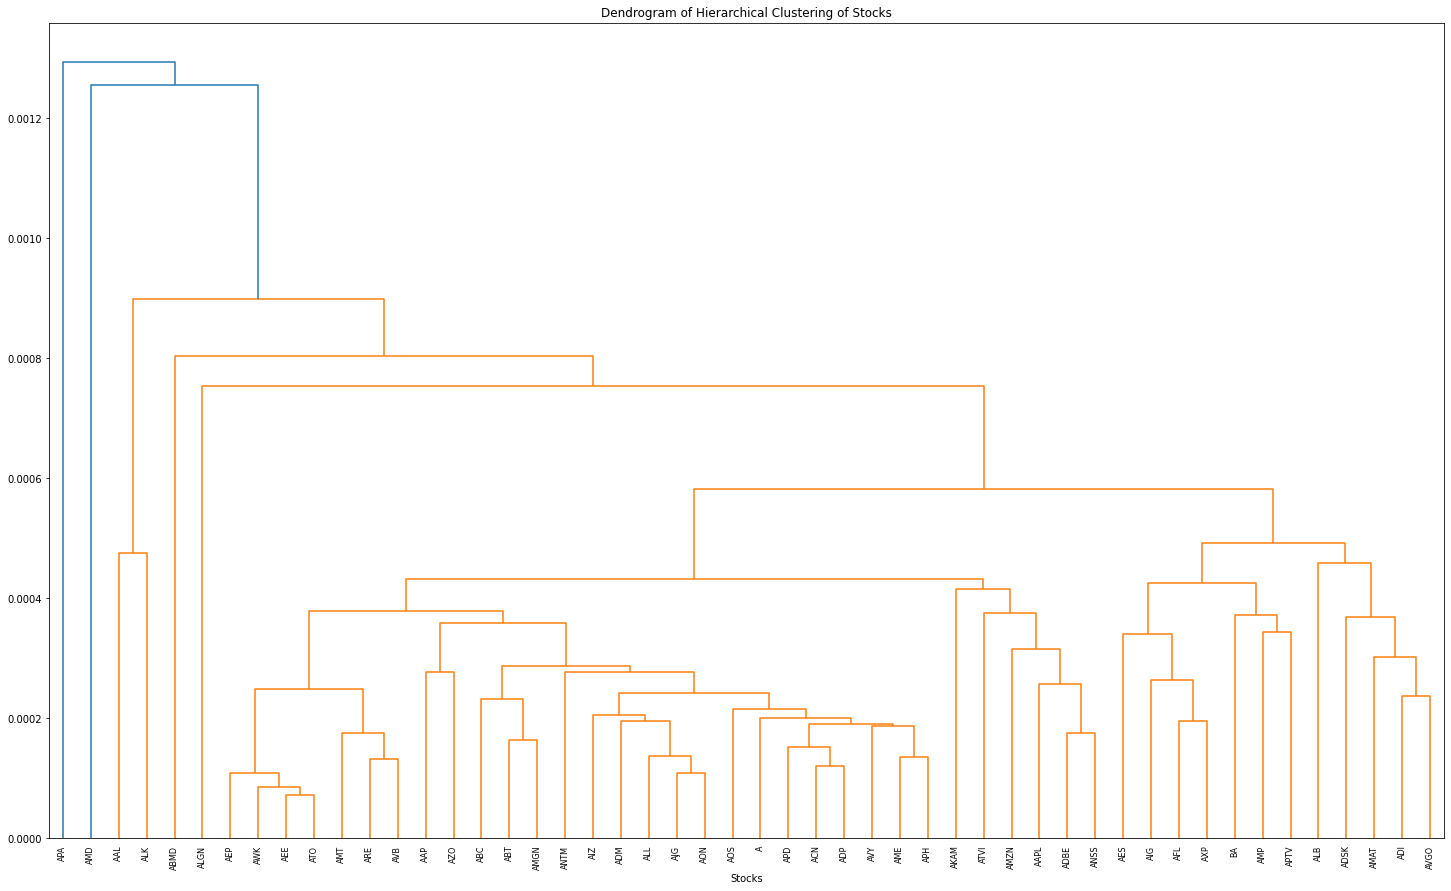

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

stocks = list(cov_daily.columns)
link = linkage(cov_daily, 'average')
fig = plt.subplots(figsize=(25,15))
d = dendrogram(link, labels = stocks)
plt.title('Dendrogram of Hierarchical Clustering of Stocks')
plt.xlabel('Stocks')
plt.show()

In [13]:
def get_stocks_reordered(log_returns_matrix):
    cov_daily = log_returns_matrix.cov()
    stocks = list(cov_daily.columns)
    link = linkage(cov_daily, 'average')
    reordered_cov_daily = cov_daily.copy()
    stocks_reordered = [stocks[i] for i in leaves_list(link)]
    reordered_cov_daily = reordered_cov_daily[stocks_reordered]
    reordered_cov_daily = reordered_cov_daily.reindex(stocks_reordered)
    return stocks_reordered, reordered_cov_daily

In [14]:
stocks_reordered, reordered_cov_daily = get_stocks_reordered(log_returns_matrix)
print(stocks_reordered)

['APA', 'AMD', 'AAL', 'ALK', 'ABMD', 'ALGN', 'AEP', 'AWK', 'AEE', 'ATO', 'AMT', 'ARE', 'AVB', 'AAP', 'AZO', 'ABC', 'ABT', 'AMGN', 'ANTM', 'AIZ', 'ADM', 'ALL', 'AJG', 'AON', 'AOS', 'A', 'APD', 'ACN', 'ADP', 'AVY', 'AME', 'APH', 'AKAM', 'ATVI', 'AMZN', 'AAPL', 'ADBE', 'ANSS', 'AES', 'AIG', 'AFL', 'AXP', 'BA', 'AMP', 'APTV', 'ALB', 'ADSK', 'AMAT', 'ADI', 'AVGO']


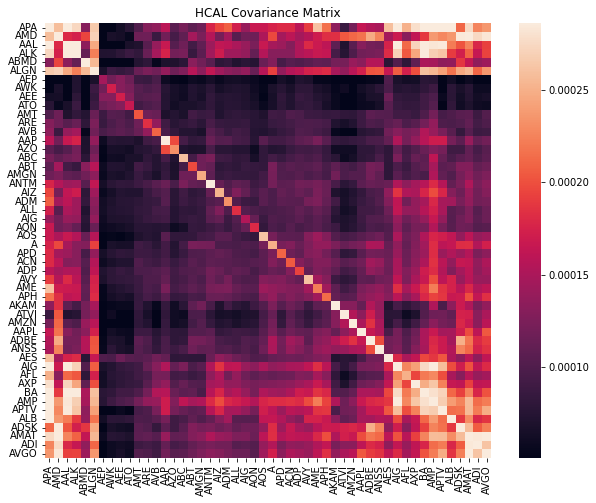

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(reordered_cov_daily, 
            xticklabels=True, 
            yticklabels=True,
            robust=True)
plt.title("HCAL Covariance Matrix")
plt.show()

### Filtered Covariance Matrix with BAHC

In [16]:
def get_bahc_cov_matrix(log_returns_matrix, stocks_reordered):
    cov_bahc = pd.DataFrame(bahc.filterCovariance(np.array(log_returns_matrix).T))
    cov_bahc.columns, cov_bahc.index = log_returns_matrix.columns, log_returns_matrix.columns
    cov_bahc = cov_bahc[stocks_reordered]
    cov_bahc = cov_bahc.reindex(stocks_reordered)
    return cov_bahc

In [17]:
cov_bahc = get_bahc_cov_matrix(log_returns_matrix, stocks_reordered)

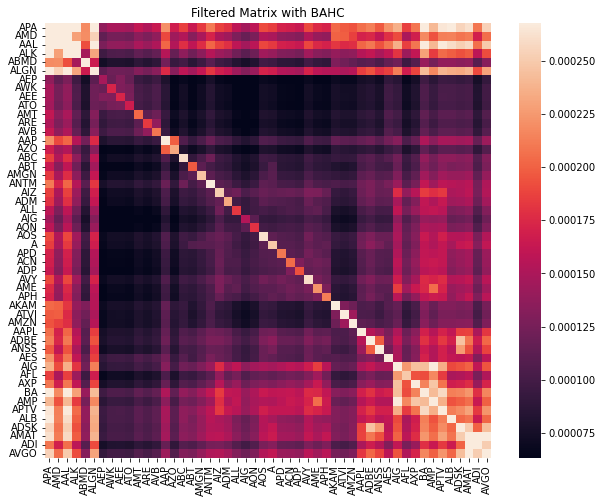

In [18]:
fig,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cov_bahc,
            xticklabels=True, 
            yticklabels=True,
            robust=True)
plt.title("Filtered Matrix with BAHC")
plt.show()

### Building the Mean Variance Portfolio

In [19]:
def min_var_portfolio(mu, cov, target_return):
    inv_cov = np.linalg.inv(cov)
    ones = np.ones(len(mu))[:, np.newaxis]
    
    a = ones.T @ inv_cov @ ones
    b = mu.T @ inv_cov @ ones
    c = mu.T.to_numpy() @ inv_cov @ mu
    
    a = a[0][0]
    b = b.loc['mu', 0]
    c = c.loc[0, 'mu']
    
    num1 = (a * inv_cov @ mu - b * inv_cov @ ones) * target_return
    num2 = (c * inv_cov @ ones- b * inv_cov @ mu)
    den = a*c - b**2
    
    w = (num1 + num2) / den
    
    var = w.T.to_numpy() @ cov.to_numpy() @ w.to_numpy()
    return w, var**0.5

In [20]:
def get_weights(mu_vector, cov_matrix, rf):
    ones = np.ones(mu_vector.shape[0])[:, np.newaxis]
    num = np.linalg.inv(cov_matrix) @ (mu_vector - rf * ones)
    den = ones.T @ np.linalg.inv(cov_matrix) @ (mu_vector - rf * ones)
    w = (np.asarray(num) / np.asarray(den))
    weights = pd.DataFrame(index = mu_vector.index, columns = ['Weights'])
    weights['Weights'] = w
    return w, weights

In [21]:
def build_frontier(portfolio, rf = 0.05, num_assets = 25, bahc_bool = False, plot_bool = False):
    training_period = 10
    portfolio = clean_portfolio(portfolio)
    portfolio_data = portfolio.data.iloc[:, :num_assets]
    stocks_universe = portfolio_data.columns
    
    log_returns_matrix = get_log_returns_matrix(portfolio_data)
    
    mu_vector = pd.DataFrame(index = stocks_universe, columns = ['mu'])
    
    if bahc_bool == False:
        cov_matrix = log_returns_matrix.cov() * 252
    else:
        stocks_reordered, _ = get_stocks_reordered(log_returns_matrix)
        cov_matrix = get_bahc_cov_matrix(log_returns_matrix, stocks_reordered) * 252
    
    for stock in stocks_universe:
        series = portfolio_data[stock]
        log_returns = np.log(series/series.shift(1)).dropna()
        ann_log_return = np.sum(log_returns) / training_period
        mu_vector.loc[stock] = ann_log_return
        
    annualized_returns = log_returns_matrix.sum() / training_period
    annualized_variance = log_returns_matrix.var() * 252

    mean_variance_stocks = pd.DataFrame(index = annualized_returns.index)
    mean_variance_stocks['mu'] = annualized_returns
    mean_variance_stocks['sigma'] = np.sqrt(annualized_variance)

    ranked_positive_returns = [i for i in annualized_returns if i > 0]
    ranked_positive_returns.sort()
    
    lo_bound_return = ranked_positive_returns[0]
    hi_bound_return = ranked_positive_returns[-1] + 1.5
    mean_variance_port = pd.DataFrame(columns = ['var'], 
                                      index = np.arange(lo_bound_return, hi_bound_return, (hi_bound_return - lo_bound_return)/20))
    for i in mean_variance_port.index:
        w_min_var, var = min_var_portfolio(mu_vector, cov_matrix, i)
        mean_variance_port.loc[i] = var
        
    w_tangency, weights_tangency = get_weights(mu_vector, cov_matrix, rf)
    cap_allocation_line = pd.DataFrame(columns = ['mu'], index = np.arange(0,0.9,0.05))
    exp_ret = (w_tangency.T @ mu_vector).iloc[0,0]
    exp_vol = np.sqrt((w_tangency.T @ cov_matrix @ w_tangency).iloc[0,0])
    tangency_port = (exp_ret, exp_vol) 

    cal_slope = (exp_ret - rf) / exp_vol
    for i in cap_allocation_line.index:
        cap_allocation_line.loc[i] = rf + i*cal_slope

    if plot_bool:
        plot_efficient_frontier(mean_variance_port, cap_allocation_line, mean_variance_stocks, tangency_port)

    return w_tangency, weights_tangency, w_min_var, log_returns_matrix, tangency_port, mean_variance_port, mean_variance_stocks

In [22]:
def plot_efficient_frontier(mean_variance_port, cap_allocation_line, mean_variance_stocks, tangency_port):
    plt.figure(figsize=(12,8))
    plt.plot(mean_variance_port['var']*100, 
             mean_variance_port.index*100, 
             label = 'Efficient Frontier')
    plt.plot(cap_allocation_line.index*100, 
             cap_allocation_line['mu']*100, 
             label = 'Capital Allocation Line', 
             linestyle = 'dashed', 
             linewidth = 1)
    plt.scatter(mean_variance_stocks['sigma']*100, 
                mean_variance_stocks['mu']*100,
                s=2, 
                c='r', 
                marker='x', 
                label = 'Individual Stocks')
    plt.scatter(tangency_port[1]*100, 
                tangency_port[0]*100, 
                label = 'Tangency portfolio', 
                marker = 'x')
    plt.title('Efficient frontier')
    plt.xlabel('Annualized Standard Deviation (%)')
    plt.ylabel('Annualized Return (%)')
    plt.legend()
    plt.show()

### Cumulative Returns of Tangency Portfolio using Unfiltered Covariance Matrix

In [23]:
def get_cumulative_returns(w, log_returns_matrix):
    weighted_returns = (w.T * log_returns_matrix)
    portfolio_returns = weighted_returns.sum(axis=1)
    # cumulative_returns = (portfolio_returns + 1).cumprod()
    cumulative_returns = (np.exp(portfolio_returns.cumsum()) - 1)
    return cumulative_returns

In [24]:
def plot_cumulative_returns(cumulative_returns):
    fig = plt.figure()
    ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
    ax1.plot(cumulative_returns)
    ax1.set_xlabel('Date')
    ax1.set_ylabel("Cumulative Returns")
    ax1.set_title("Portfolio Cumulative Returns")
    plt.show()

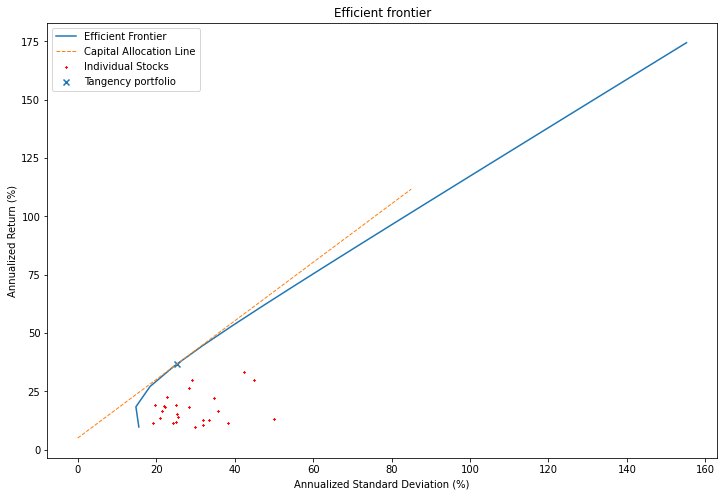

In [25]:
w_tangency, weights_tangency, w_min_var, log_returns_matrix, tangency_port, mean_variance_port, mean_variance_stocks = build_frontier(portfolio, rf = 0.05, num_assets = 25, bahc_bool = False, plot_bool = True)

In [26]:
print('Tangent Portfolio Unfiltered Covariance Matrix: Expected Return of {:f} and Volatility of {:f}'.format(tangency_port[0], tangency_port[1]))

Tangent Portfolio Unfiltered Covariance Matrix: Expected Return of 0.368964 and Volatility of 0.254216


In [27]:
weighted_returns = w_tangency.T * log_returns_matrix
cumulative_log_returns = weighted_returns.sum(axis = 1).cumsum()

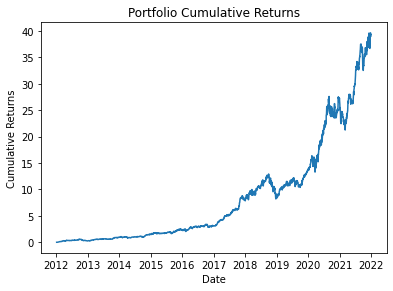

In [28]:
plot_cumulative_returns(np.exp(cumulative_log_returns)-1)

### Cumulative Returns of Tangency Portfolio using BAHC-Filtered Covariance Matrix

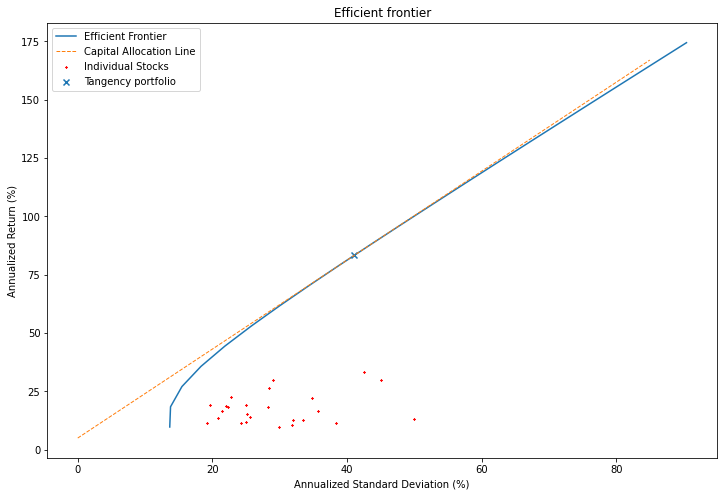

In [29]:
w_tangency_bahc, weights_tangency_bahc, w_min_var_bahc, log_returns_matrix_bahc, tangency_port_bahc, mean_variance_port_bahc, mean_variance_stocks_bahc = build_frontier(portfolio, rf = 0.05, num_assets = 25, bahc_bool = True, plot_bool = True)

In [30]:
weighted_returns_bahc = w_tangency_bahc.T * log_returns_matrix_bahc
cum = weighted_returns_bahc.sum(axis = 1).cumsum()

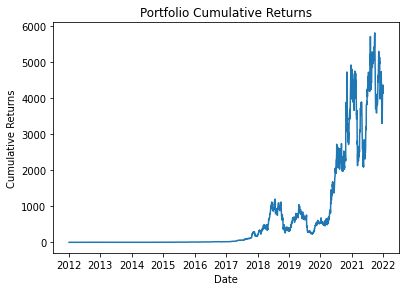

In [31]:
plot_cumulative_returns(np.exp(cum) - 1)

In [43]:
print('Tangent Portfolio BAHC-Filtered Covariance Matrix: Expected Return of {:f} and Volatility of {:f}'.format(tangency_port_bahc[0], tangency_port_bahc[1]))

Tangent Portfolio BAHC-Filtered Covariance Matrix: Expected Return of 0.822822 and Volatility of 0.406949


### Tangency Portfolio with Rolling Window

In [32]:
def get_rolling_tangency_portfolio(portfolio, window = 90, rf = 0.05, num_assets = 25, step = 1, bahc_bool = False):
    training_period = 10
    portfolio = clean_portfolio(portfolio)
    portfolio_data = portfolio.data.iloc[:, :num_assets]
    stocks_universe = portfolio_data.columns
    
    log_returns_matrix = get_log_returns_matrix(portfolio_data)
    mu_vector = pd.DataFrame(index = stocks_universe, columns = ['mu'])
    
    portfolio_returns = pd.Series([0] * window, index = log_returns_matrix.index[0:window])
    for i in range(0, len(log_returns_matrix) - window, step):
        window_log_returns_matrix = log_returns_matrix[i: i+window].copy()
        next_log_returns_matrix = log_returns_matrix[i+window: i+window+step].copy()
        if bahc_bool == False:
            cov_matrix = log_returns_matrix.cov() * 252
        else:
            stocks_reordered, _ = get_stocks_reordered(window_log_returns_matrix)
            cov_matrix = get_bahc_cov_matrix(window_log_returns_matrix, stocks_reordered) * 252

        for stock in stocks_universe:
            series = portfolio_data[stock]
            log_returns = np.log(series/series.shift(1)).dropna()
            ann_log_return = np.sum(log_returns) / training_period
            mu_vector.loc[stock] = ann_log_return

        w_tangency, _ = get_weights(mu_vector, cov_matrix, rf)
        portfolio_returns = pd.concat([portfolio_returns, next_log_returns_matrix.apply(lambda x: w_tangency.T @ x, axis = 1)])
        # cumulative_returns = (portfolio_returns_tangency + 1).cumprod()
    # cumulative_returns = np.exp(portfolio_returns.cumsum()) - 1
        
    return portfolio_returns

#### Cumulative Returns of Tangency Portfolio with Rolling Window of 90 days and BAHC-Filtered Covariance Matrix

In [49]:
portfolio_returns_tangency_bahc = get_rolling_tangency_portfolio(portfolio, bahc_bool = True)

In [50]:
p = portfolio_returns_tangency_bahc.copy()
for i in range(0, len(p)):
    if isinstance(p[i], int) == False:
        p[i] = p[i][0]
p = pd.DataFrame(np.array(p, dtype = float))
p.index = portfolio_returns_tangency_bahc.index

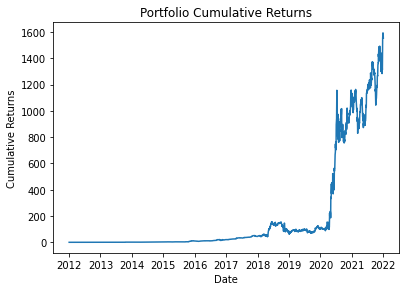

In [51]:
window_cumulative_returns_tangency_bahc = np.exp(p.cumsum()) - 1
plot_cumulative_returns(window_cumulative_returns_tangency_bahc)

#### Cumulative Returns of Tangency Portfolio with Rolling Window of 90 days and Unfiltered Covariance Matrix

In [52]:
portfolio_returns_tangency = get_rolling_tangency_portfolio(portfolio, bahc_bool = False)

In [53]:
p = portfolio_returns_tangency.copy()
for i in range(0, len(p)):
    if isinstance(p[i], int) == False:
        p[i] = p[i][0]
p = pd.DataFrame(np.array(p, dtype = float))
p.index = portfolio_returns_tangency.index

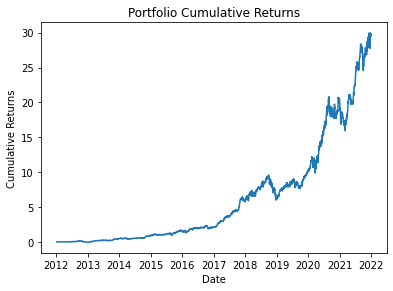

In [54]:
window_cumulative_returns_tangency = np.exp(p.cumsum()) - 1
plot_cumulative_returns(window_cumulative_returns_tangency)

#### Comparison Tangency Portfolio of BAHC vs Unfiltered with Rolling Window of 90 days

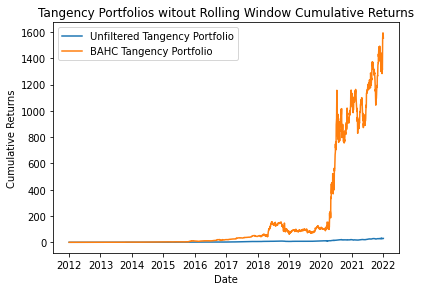

In [55]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(window_cumulative_returns_tangency, label = 'Unfiltered Tangency Portfolio')
ax1.plot(window_cumulative_returns_tangency_bahc, label = 'BAHC Tangency Portfolio')
ax1.set_xlabel('Date')
ax1.set_ylabel("Cumulative Returns")
ax1.set_title("Tangency Portfolios witout Rolling Window Cumulative Returns")
plt.legend()
plt.show()

#### Cumulative Returns of Tangency Portfolio with Rolling Windos of 180 days and Unfiltered Covariance Matrix

In [ ]:
portfolio_returns_tangency_180 = get_rolling_tangency_portfolio(portfolio, window = 180, bahc_bool = False)
p_180 = portfolio_returns_tangency_180.copy()
for i in range(0, len(p_180)):
    if isinstance(p_180[i], int) == False:
        p_180[i] = p_180[i][0]
p_180 = pd.DataFrame(np.array(p_180, dtype = float))
p_180.index = portfolio_returns_tangency_180.index
window_cumulative_returns_tangency_180 = np.exp(p_180.cumsum()) - 1
plot_cumulative_returns(window_cumulative_returns_tangency_180)

#### Cumulative Returns of Tangency Portfolio with Rolling Windos of 180 days and BAHC-Filtered Covariance Matrix

In [ ]:
portfolio_returns_tangency_bahc_180 = get_rolling_tangency_portfolio(portfolio, window = 180, bahc_bool = True)
p_180_bahc = portfolio_returns_tangency_bahc_180.copy()
for i in range(0, len(p_180_bahc)):
    if isinstance(p_180_bahc[i], int) == False:
        p_180_bahc[i] = p_180_bahc[i][0]
p_180_bahc = pd.DataFrame(np.array(p_180_bahc, dtype = float))
p_180_bahc.index = portfolio_returns_tangency_bahc_180.index
window_cumulative_returns_tangency_bahc_180 = np.exp(p_180_bahc.cumsum()) - 1
plot_cumulative_returns(window_cumulative_returns_tangency_bahc_180)

## trying shit without log

In [39]:
# # mean daily returns
# returns = portfolio.data.pct_change()
# mean_daily_returns = returns.mean()

# # returns annual
# returns_annual = mean_daily_returns * 250


def get_rolling_tangency_portfolio_new(portfolio, window = 90, rf = 0.05, num_assets = 25, step = 1, bahc_bool = False):
    training_period = 10 # we take data from the last 10 years
    portfolio = clean_portfolio(portfolio)
    portfolio_data = portfolio.data.iloc[:, :num_assets]
    stocks_universe = portfolio_data.columns
    
    returns_matrix = portfolio_data.pct_change()
    
    returns_matrix.fillna(0, inplace=True)
    returns_matrix = returns_matrix[(returns_matrix.T != 0).any()]
    
    # log_returns_matrix = get_log_returns_matrix(portfolio_data)
    mu_vector = pd.DataFrame(index = stocks_universe, columns = ['mu'])
    
    portfolio_returns = pd.Series([0] * window, index = returns_matrix.index[0:window])
    for i in range(0, len(returns_matrix) - window, step):
        window_returns_matrix = returns_matrix[i: i+window].copy()
        next_returns_matrix = returns_matrix[i+window: i+window+step].copy()
        if bahc_bool == False:
            cov_matrix = returns_matrix.cov() * 252
        else:
            stocks_reordered, _ = get_stocks_reordered(window_returns_matrix)
            cov_matrix = get_bahc_cov_matrix(window_returns_matrix, stocks_reordered) * 252

        for stock in stocks_universe:
            series = portfolio_data[stock]
            log_returns = np.log(series/series.shift(1)).dropna()
            ann_log_return = np.sum(log_returns) / training_period
            mu_vector.loc[stock] = ann_log_return

        w_tangency, _ = get_weights(mu_vector, cov_matrix, rf)
        portfolio_returns = pd.concat([portfolio_returns, next_returns_matrix.apply(lambda x: w_tangency.T @ x, axis = 1)])
        cumulative_returns = (portfolio_returns + 1).cumprod()
    # cumulative_returns = np.exp(portfolio_returns.cumsum()) - 1
        
    return portfolio_returns, cumulative_returns, returns_matrix

In [34]:
portfolio_returns2, cumulative_returns2 = get_rolling_tangency_portfolio_new(portfolio, window = 90, rf = 0.05, num_assets = 25, step = 1, bahc_bool = False)

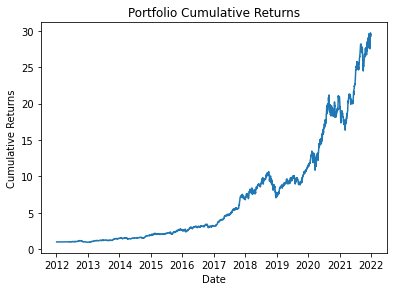

In [35]:
plot_cumulative_returns(cumulative_returns2)

In [ ]:
portfolio_returns2, cumulative_returns2, ret_matrix2 = get_rolling_tangency_portfolio_new(portfolio, window = 90, rf = 0.05, num_assets = 25, step = 1, bahc_bool = True)

In [ ]:
cumu = get_cumulative_returns(portfolio_returns2, ret_matrix2)
plot_cumulative_returns(cumu)